<a href="https://colab.research.google.com/github/Pablo-Lemos/orbits/blob/master/simple_momentum_orbit_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use a simple MLP to predicted the updated momenta and positions of the Earth-Mercury system

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from keras.layers import Dense, Dropout, LeakyReLU, Input
from keras.layers import concatenate, BatchNormalization
from keras.models import Model
from keras import optimizers

from io import BytesIO
from tensorflow.python.lib.io import file_io

from google.colab import auth
auth.authenticate_user()

from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos if x.device_type == 'GPU'])

Using TensorFlow backend.


['/device:GPU:0']


In [0]:
class simple_leaky:
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, learning_rate=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(100, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x2 = Dense(100, kernel_initializer='normal')(x1)
        x2 = LeakyReLU(alpha=0.1)(x2)
        # x2 = Dropout(0.5)(x2)
        x3 = Dense(100, kernel_initializer='normal')(x2)
        x3 = LeakyReLU(alpha=0.1)(x3)
        x3 = Dense(100, kernel_initializer='normal')(x3)
        x3 = LeakyReLU(alpha=0.1)(x3)
        # x3 = Dropout(0.5)(x3)
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)
        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            # dense_model.compile(optimizer='adam', loss='mse')
            dense_model.compile(optimizer='adam', loss='mean_absolute_error')
        else:
            dense_model.compile(optimizer=optimizers.Adam(lr=self.learning_rate), loss='mean_absolute_error')

        return dense_model

In [0]:
def generate_target(orbit_array, shuffle=False, rescale = None):
    """
    Takes a single orbit and splits into input target points
    """

    input_array = orbit_array[:-1,:]
    target_array = orbit_array[1:,:]

    if shuffle:
      indices = np.arange(input_array.shape[0])
      np.random.shuffle(indices)
      input_array = input_array[indices]
      target_array = target_array[indices]

    if rescale is not None:
      rescale = np.outer(np.array(rescale), np.ones((input_array.shape[0],))).T
      input_array = rescale*input_array
      target_array = rescale*target_array

    return input_array, target_array

# Load Data

In [0]:
n_body = 2
n_arrays = 50
n_training = 40
n_validation = n_arrays - n_training
mass_ratio =  1.98892e30/0.33011e24

rescale_list = [0.05*mass_ratio,0.05*mass_ratio,0.05*mass_ratio,0.05*mass_ratio,
                1.,1.,0.05,0.05]

assert n_validation > 0

In [0]:
for i in np.arange(1,n_training):
  
  if i%10==0:
    print(i)

  orbit_temp = np.load(BytesIO(file_io.read_file_to_string('gs://orbits_ml/initial_data/planet_' + str(i) + '.npy',
                                                                 binary_mode=True)))
  
  
  orbit_temp  = np.vstack([orbit_temp[0,:,0],orbit_temp[0,:,1],
                           orbit_temp[0,:,3],orbit_temp[0,:,4],
                           orbit_temp[1,:,0],orbit_temp[1,:,1],
                           orbit_temp[1,:,3],orbit_temp[1,:,4]]).T

  input_temp, target_temp = generate_target(orbit_temp, shuffle=True,
                                            rescale = rescale_list)

  if i==1:
  # if i==0:
    input_training = np.copy(input_temp)
    target_training = np.copy(target_temp)
  else:
    input_training = np.vstack([input_training, input_temp])
    target_training = np.vstack([target_training, target_temp])


for i in np.arange(n_training,n_arrays):  

  if i%10==0:
    print(i)

  orbit_temp = np.load(BytesIO(file_io.read_file_to_string('gs://orbits_ml/initial_data/planet_' + str(i) + '.npy',
                                                                 binary_mode=True)))
  
  orbit_temp  = np.vstack([orbit_temp[0,:,0],orbit_temp[0,:,1],
                           orbit_temp[0,:,3],orbit_temp[0,:,4],
                           orbit_temp[1,:,0],orbit_temp[1,:,1],
                           orbit_temp[1,:,3],orbit_temp[1,:,4]]).T
  
  input_temp, target_temp = generate_target(orbit_temp, shuffle=True,
                                            rescale = rescale_list)
  
  if i==n_training:
    input_validation = np.copy(input_temp)
    target_validation = np.copy(target_temp)
  else:
    input_validation = np.vstack([input_validation, input_temp])
    target_validation = np.vstack([target_validation, target_temp])

10
20
30
40


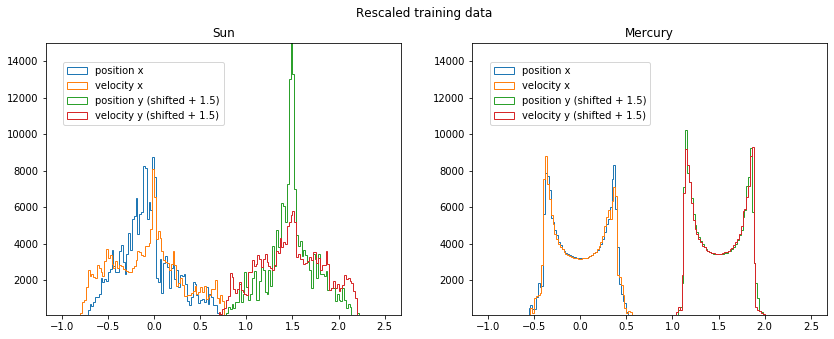

In [0]:
_ = plt.figure(figsize=(14,5))
_ = plt.suptitle('Rescaled training data')
_ = plt.subplot(1,2,1), plt.title('Sun')
_ = plt.hist(target_training[:,0], bins = np.linspace(-1,1,101),
             label = 'position x', histtype='step')
_ = plt.hist(target_training[:,2], bins = np.linspace(-1,1,101),
             label = 'velocity x', histtype='step'), plt.legend()

_ = plt.hist(target_training[:,1] + 1.5, bins = np.linspace(0.5,2.5,101),
             label = 'position y (shifted + 1.5)', histtype='step')
_ = plt.hist(target_training[:,3]+ 1.5, bins = np.linspace(0.5,2.5,101),
             label = 'velocity y (shifted + 1.5)', histtype='step'), plt.legend(loc=(0.05,0.7))
_ = plt.ylim(100,15000)

_ = plt.subplot(1,2,2), plt.title('Mercury')
_ = plt.hist(target_training[:,4], bins = np.linspace(-1,1,101),
             label = 'position x', histtype='step')
_ = plt.hist(target_training[:,5], bins = np.linspace(-1,1,101),
             label = 'velocity x', histtype='step'), plt.legend()

_ = plt.hist(target_training[:,6] + 1.5, bins = np.linspace(0.5,2.5,101),
             label = 'position y (shifted + 1.5)', histtype='step')
_ = plt.hist(target_training[:,7]+ 1.5, bins = np.linspace(0.5,2.5,101),
             label = 'velocity y (shifted + 1.5)', histtype='step'), plt.legend(loc=(0.05,0.7))
_ = plt.ylim(100,15000)

# Train Model

In [0]:
model_instance = simple_leaky(input_training.shape[1], target_training.shape[1], learning_rate=1e-3)
predictor = model_instance.model()

8
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               900       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 100)               0 

In [0]:
history = predictor.fit(input_training[:], (target_training[:]-input_training)*100.,
                         epochs =30,batch_size = 200, shuffle=True,
                         validation_data = (input_validation,
                                            100.*(target_validation-input_validation)))

Train on 194961 samples, validate on 49990 samples
Epoch 1/30
194961/194961 [==============================] - 4s 21us/step - loss: 0.0128 - val_loss: 0.0106
Epoch 2/30
194961/194961 [==============================] - 4s 19us/step - loss: 0.0047 - val_loss: 0.0083
Epoch 3/30
194961/194961 [==============================] - 4s 19us/step - loss: 0.0034 - val_loss: 0.0067
Epoch 4/30
194961/194961 [==============================] - 4s 19us/step - loss: 0.0026 - val_loss: 0.0061
Epoch 5/30
194961/194961 [==============================] - 4s 19us/step - loss: 0.0024 - val_loss: 0.0053
Epoch 6/30
194961/194961 [==============================] - 4s 19us/step - loss: 0.0022 - val_loss: 0.0050
Epoch 7/30
194961/194961 [==============================] - 4s 19us/step - loss: 0.0020 - val_loss: 0.0053
Epoch 8/30
194961/194961 [==============================] - 4s 19us/step - loss: 0.0020 - val_loss: 0.0050
Epoch 9/30
194961/194961 [==============================] - 4s 19us/step - loss: 0.0018 - val

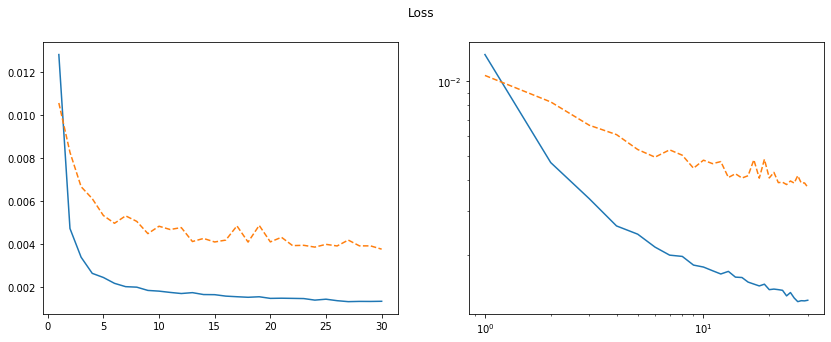

In [0]:
_ = plt.figure(figsize=(14,5))
_ = plt.suptitle('Loss')
_ = plt.subplot(1,2,1)
_ = plt.plot(np.array(history.epoch)+1., history.history['loss'])
_ = plt.plot(np.array(history.epoch)+1., history.history['val_loss'], '--')

_ = plt.subplot(1,2,2)
_ = plt.loglog(np.array(history.epoch)+1., history.history['loss'])
_ = plt.plot(np.array(history.epoch)+1., history.history['val_loss'], '--')

-1.4995223061364804e-05


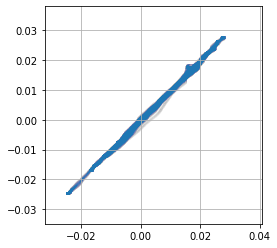

In [0]:
_ = plt.scatter(predictor.predict(np.atleast_2d(input_validation))[:,0],
                100.*(target_validation-input_validation)[:,0],
                alpha = 3e-3, marker='.')
_ = plt.axis('equal')
_ = plt.axis('square'), plt.grid(True)

print(np.median(predictor.predict(np.atleast_2d(input_validation))[:,0]-
                100.*(target_validation-input_validation)[:,0]))

0.0005876722125326417


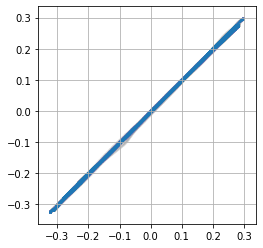

In [0]:
_ = plt.scatter(predictor.predict(np.atleast_2d(input_validation))[:,4],
                100.*(target_validation-input_validation)[:,4],
                alpha = 3e-3, marker='.')
_ = plt.axis('equal')
_ = plt.axis('square'), plt.grid(True)

print(np.median(predictor.predict(np.atleast_2d(input_validation))[:,4]-
                100.*(target_validation-input_validation)[:,4]))

# Load example and evaluate full orbit

In [0]:
orbit_example = np.load(BytesIO(file_io.read_file_to_string('gs://orbits_ml/initial_data/planet_49.npy',
                                                                 binary_mode=True)))

orbit_example  = np.vstack([orbit_example[0,:,0]*0.05*mass_ratio,
                            orbit_example[0,:,1]*0.05*mass_ratio,
                            orbit_example[0,:,3]*0.05*mass_ratio,
                            orbit_example[0,:,4]*0.05*mass_ratio,
                           orbit_example[1,:,0],orbit_example[1,:,1],
                           orbit_example[1,:,3]*0.05,orbit_example[1,:,4]*0.05]).T


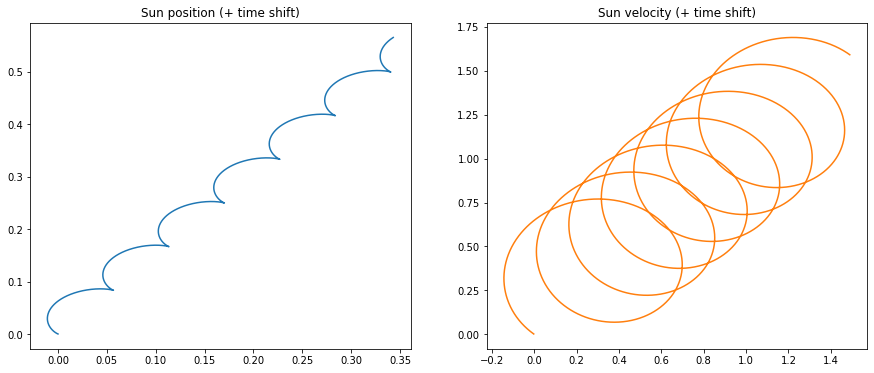

In [0]:
_ = plt.figure(figsize=(15,6)), plt.subplot(1,2,1), plt.title('Sun position (+ time shift)')
_ = plt.plot(orbit_example[:,0]  ,
             orbit_example[:,1])
_ = plt.subplot(1,2,2), plt.title('Sun velocity (+ time shift)')
_ = plt.plot(orbit_example[:,2]+ np.arange(5000)*2e-4,
             orbit_example[:,3]+ np.arange(5000)*2e-4, c='C1')

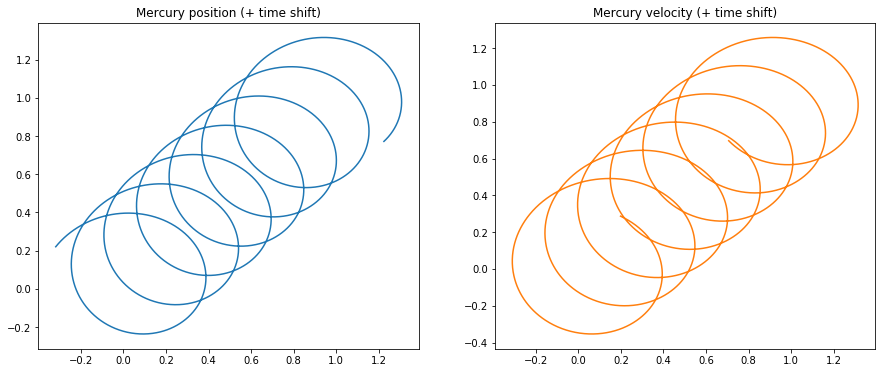

In [0]:
_ = plt.figure(figsize=(15,6)), plt.subplot(1,2,1), plt.title('Mercury position (+ time shift)')
_ = plt.plot(orbit_example[:,4] + np.arange(5000)*2e-4 ,
             orbit_example[:,5]+ np.arange(5000)*2e-4)
_ = plt.subplot(1,2,2), plt.title('Mercury velocity (+ time shift)')
_ = plt.plot(orbit_example[:,6]+ np.arange(5000)*2e-4,
             orbit_example[:,7]+ np.arange(5000)*2e-4, c='C1')

In [0]:
orbit_example_prediction = np.copy(orbit_example)
for i in range(orbit_example_prediction.shape[0]):
  if i%500==0:
    print(str(i) + '/' + str(orbit_example_prediction.shape[0]))
  if i > 0:
    delta = predictor.predict(np.atleast_2d(orbit_example_prediction[i-1,:]))/100. 
    if i==1:
      print(delta,orbit_example[1,:] - orbit_example[0])
    orbit_example_prediction[i,:] = orbit_example_prediction[i-1] + delta

0/5000
[[ 1.5131477e-06 -2.4580163e-06 -2.1560306e-03  1.5289997e-03
   1.5167324e-03  2.1870972e-03  2.1591862e-03 -1.5223675e-03]] [-1.62925064e-06  1.11853088e-06 -2.15581404e-03  1.49083447e-03
  1.51352269e-03  2.15054672e-03  2.15581404e-03 -1.49083447e-03]
500/5000
1000/5000
1500/5000
2000/5000
2500/5000
3000/5000
3500/5000
4000/5000
4500/5000


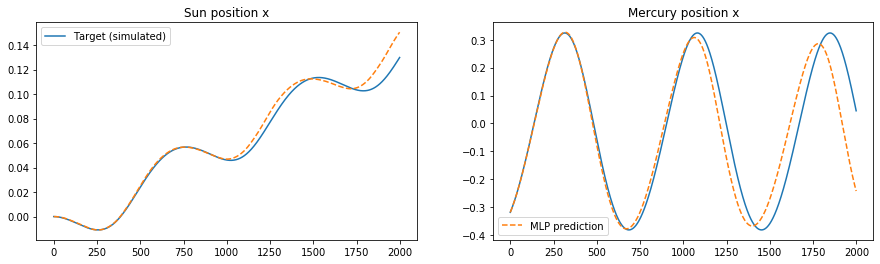

In [0]:
_ = plt.figure(figsize=(15,4)), plt.subplot(1,2,1)
_ = plt.title('Sun position x'), plt.plot(orbit_example[:2000,0], label='Target (simulated)')
_ = plt.plot(orbit_example_prediction[:2000,0], '--') , plt.legend()
_ = plt.subplot(1,2,2)
_ = plt.title('Mercury position x'), plt.plot(orbit_example[:2000,4])
_ = plt.plot(orbit_example_prediction[:2000,4], '--', label='MLP prediction')
_ = plt.legend()

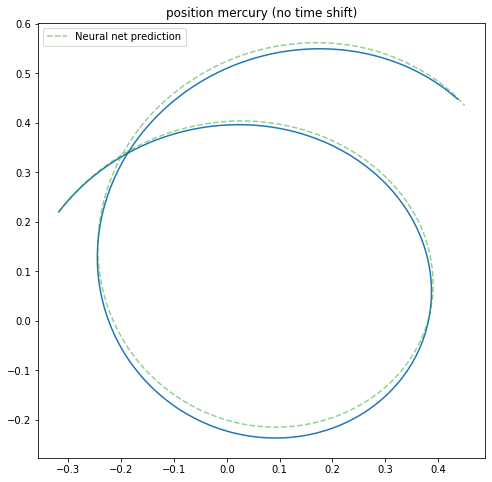

In [0]:
_ = plt.figure(figsize=(8,8)), plt.title('position mercury (no time shift)')
_ = plt.plot(orbit_example[:1000,4] + np.arange(1000)*2e-4,
             orbit_example[:1000,5]+ np.arange(1000)*2e-4)
_ = plt.plot(orbit_example_prediction[:1000,4]+ np.arange(1000)*2e-4 ,
             orbit_example_prediction[:1000,5]+ np.arange(1000)*2e-4, '--', c='C2', alpha=0.5, label='Neural net prediction')
_ = plt.legend()

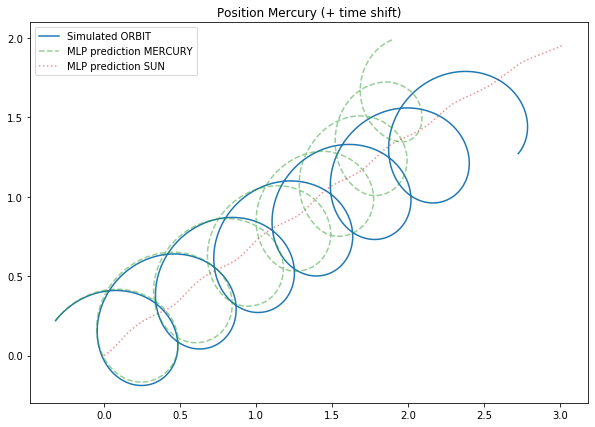

In [0]:
_ = plt.figure(figsize=(10,7))
_ = plt.title('Position Mercury (+ time shift)')
_ = plt.plot(orbit_example[:,4] + np.arange(5000)*5e-4,
             orbit_example[:,5]+ np.arange(5000)*3e-4,
             label = 'Simulated ORBIT', )
_ = plt.plot(orbit_example_prediction[:,4]+ np.arange(5000)*5e-4 ,
             orbit_example_prediction[:,5]+ np.arange(5000)*3e-4, '--', c='C2',
             label = 'MLP prediction MERCURY', alpha=0.5)

_ = plt.plot(orbit_example_prediction[:,0]+ np.arange(5000)*5e-4 ,
             orbit_example_prediction[:,1]+ np.arange(5000)*3e-4, ':', c='C3',
             label = 'MLP prediction SUN', alpha=0.5)

_ = plt.legend()